In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import csv
from pathlib import Path
import sys
sys.path.append("../../")
from Plots.style import *
import pandas as pd
import seaborn as sns
import glob
import contextlib
from PIL import Image

drive_path = Path("../../GetData/Python/Data/")

2024-06-19 16:47:59.185423: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 16:47:59.236647: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 16:47:59.236705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 16:47:59.237862: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-19 16:47:59.244413: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-19 16:47:59.245157: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Model

In [2]:
class VAE(tf.keras.Model):
  """Variational autoencoder."""

  def __init__(self, latent_dim, kernel_size = 3, lattice_size = 32):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(32, (kernel_size, kernel_size), activation='relu', padding="same", input_shape=(32, 32, 1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(latent_dim + latent_dim)
          ]
     )

    self.decoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=kernel_size, strides=(1, 1), padding="same"),
        ]
    )

  def call(self, inputs):
    mean, logvar = self.encode(inputs)
    z = self.reparameterize(mean, logvar)
    reconstructed = self.decode(z)
    return reconstructed

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss_ediff(model, x, alpha = 1e-4):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  energy = calc_energy(2 * x - 1)
  energy_predicted = calc_energy(2 * tf.sigmoid(x_logit) - 1)
  diff = tf.reduce_mean(tf.square(energy - energy_predicted))
  return -tf.reduce_mean(logpx_z + logpz - logqz_x) + alpha * diff

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  #energy = calc_energy(x)
  #energy_predicted = calc_energy(tf.sigmoid(x_logit))
  #diff = tf.reduce_mean(tf.square(energy - energy_predicted))
  return -tf.reduce_mean(logpx_z + logpz - logqz_x) #+ diff
    
@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Training

In [3]:
def plot_spins(path, predictions, originals, epoch):
  fig, axs = plt.subplots(nrows=len(predictions), ncols=3, figsize=(15, 20))
  fig.suptitle(f'Epoch: {epoch}', fontsize=16)
  fig.subplots_adjust(top=0.95)  # Adjust the top of the subplots

  for index in range(len(predictions)):
      axs[index, 0].imshow(predictions[index, :, :, 0], vmin=0, vmax=1)
      axs[index, 0].axis('off')
      axs[index, 0].set_title("Spin +1 probability map")

      axs[index, 1].imshow(np.random.binomial(1, predictions[index, :, :, 0]), vmin=0, vmax=1)
      axs[index, 1].axis('off')
      axs[index, 1].set_title("Predicted from binomial")

      axs[index, 2].imshow(originals[index, :, :, 0], vmin=0, vmax=1)
      axs[index, 2].axis('off')
      axs[index, 2].set_title("Original Sample")

  plt.savefig(path, dpi=100)
  plt.show()

def generate_and_save_images(model, epoch, test_sample, outdir):
  predictions = make_prediction(model, test_sample)
  plot_spins(outdir / "Images" / f'image_at_epoch_{epoch}.svg', predictions, test_sample, epoch)

def make_prediction(model, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    return predictions

def sample(num_examples_to_generate, model):
    random_mean = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
    log_var = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

    z = model.reparameterize(random_mean, log_var)
    predictions = model.sample(z)
    return predictions

def calcEnergy(mat):
    '''Energy of a given configuration'''
    matrix_sum = get_neighbour_sum_matrix(mat)
    return - np.sum(np.multiply(matrix_sum, mat))

def calcMag(mat):
    '''Magnetization of a given configuration'''
    mag = np.sum(mat)
    return mag

def get_neighbour_sum_matrix(mat):
    """Matrix of the sum of spin values for all neighboring cells."""
    # Define shifts for different directions
    shifts = [
        (1, 1),  # Right
        (-1, 1),  # Left
        (-1, 0),  # Up
        (1, 0),  # Down
        (-1, 1),  # Up-Right
        (1, 1),  # Down-Right
        (-1, -1),  # Up-Left
        (1, -1),  # Down-Left
    ]

    # Initialize an empty matrix for the sum of neighboring cells
    neighbor_sum = np.zeros_like(mat)

    # Iterate through each shift and accumulate the values in neighbor_sum
    for shift in shifts:
        shifted_mat = np.roll(mat, shift=shift, axis=(0, 1))
        neighbor_sum += shifted_mat

    return neighbor_sum

def cost_function_plot(loss_list, outdir):
  plt.figure()
  plt.plot(loss_list)
  plt.xlabel("Epoch")
  plt.ylabel("Cost function")
  plt.savefig(outdir / "loss_function.svg")

def process_data(spin_image):
  df = pd.DataFrame({'image': list(spin_image)})
  df['Magnetization'] = df['image'].apply(calcMag)
  df['Energy'] = df['image'].apply(calcEnergy)
  df.drop(columns='image', inplace=True)
  return df

def sample_data_plots(model, test_size, batch_size, test_set, outdir):
  sample_data = []
  num = test_size
  for _ in range(batch_size):
    sample_data.append(sample(num, model))
  spin_sample = tf.concat(sample_data, axis = 0)
  preds = []
  reals = []
  for test_x in test_set:
    test_x = plus_encode_data(test_x)
    preds.append(make_prediction(model, test_x))
    reals.append(test_x)

  predicted_spin = np.concatenate(preds)
  real_spin = np.concatenate(reals)
  predicted_spin =  2 * np.random.binomial(1, predicted_spin) - 1
  real_spin =  2 * real_spin - 1
  spin_sample = 2 * np.random.binomial(1, spin_sample) - 1
  df = get_statistics_df(predicted_spin, real_spin, spin_sample)
  sns.displot(df, x = 'Magnetization', kind ='kde', hue='Algorithm')
  plt.savefig(outdir / f"mag_{temp}.png")
  sns.displot(df, x = 'Energy', kind ='kde', hue='Algorithm')
  plt.savefig(outdir / f"energy_{temp}.png")

def get_statistics_df(perdicted_spin, real_spin, spin_sample):
  df_model = process_data(perdicted_spin)
  df_model['Algorithm'] = 'VAE testset'

  df_test = process_data(real_spin)
  df_test['Algorithm'] = 'Wolff testset'

  df_sample = process_data(spin_sample)
  df_sample ['Algorithm'] = 'VAE sample'

  df = pd.concat([df_model, df_test, df_sample])
  return df

In [4]:
def load_starting_weights(model):
    dummy_input = tf.zeros((1, 32, 32, 1))
    model(dummy_input)
    model.load_weights("Results/reference/vae2.2.h5")

def load_weights_at_t(t, date,model):
    dummy_input = tf.zeros((1, 32, 32, 1))
    model(dummy_input)
    model.load_weights("Results" / date / f"{t:.2}" /f"vae{t:.2}.h5")
    
def plus_encode_data(data):
    data = tf.reshape(data, shape=(data.shape[0], -1))
    mean_data = tf.reduce_mean(data, axis=1, keepdims=True)
    need_change = tf.cast(mean_data < 0.5, data.dtype)
    data = data * (1 - 2 * need_change) + need_change
    data = tf.reshape(data, shape=(-1, 32, 32, 1))
    return data   

# Dataset

In [5]:
from IPython import display
from time import time
from datetime import datetime
from queue import Queue
from Model.input_pipeline import dataset_tfrecord_pipeline

def train_at_t(temp, model, results, batch_size = 100, epochs = 50, latent_dim = 200, num_examples_to_generate = 5, test_size = 100):
  # Folders for storing the results and dataset
  trainset_path = drive_path /  f"Data{temp:.2}.tfrecord"
  testset_path = drive_path / f"TestData{temp:.2}.tfrecord"

  outdir = results / f"{temp:.2}"
  outdir.mkdir(exist_ok = True)
  images = outdir / "Images"
  images.mkdir(exist_ok = True)

  train_set = dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
  test_set = dataset_tfrecord_pipeline(testset_path, flatten=False, batch_size=batch_size)
  loss_monitor = 3 * [False]

  # Test sample for image generation
  assert batch_size >= num_examples_to_generate
  for test_batch in test_set.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :, :]
  #generate_and_save_images(model, 0, test_sample, outdir)

  # Training loop
  loss_list = []
  for epoch in range(1, epochs + 1):
    time_start = time()
    for train_x in train_set:
      train_x = plus_encode_data(train_x)
      train_step(model, train_x, optimizer)
    loss = tf.keras.metrics.Mean()
    for test_x in test_set:
      test_x = plus_encode_data(test_x)
      loss(compute_loss(model, test_x))

    elbo = -loss.result()
    loss_list.append(loss.result().numpy())

    # Early stopping for VAE
    if epoch > 1:
      loss_monitor.pop(-1)
      loss_monitor.insert(0, loss_list[-1] - loss_list[-2] > 0)
      if all(loss_monitor):
        print("STOP!")
        break

    # Spins from testset
    display.clear_output(wait=False)
    elapsed = time() - time_start
    print(f'Epoch: {epoch}, Test set ELBO: {elbo}, Time needed: {elapsed}')
      
  generate_and_save_images(model, epochs, test_sample, outdir)
  # Results
  cost_function_plot(loss_list, outdir)
  #sample_data_plots(model, test_size, batch_size, test_set, outdir)
  model.save_weights(results / f'vae{temp:.2}.h5',save_format='h5')


In [6]:
epochs = 150
latent_dim = 200
num_examples_to_generate = 5
batch_size = 100
temps = np.arange(2.8, 3.05, 0.1)
model = VAE(latent_dim, lattice_size = 32)
optimizer = tf.keras.optimizers.Adam(1e-4)

2024-04-16 18:51:32.104581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30955 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


In [7]:
# Format the date as a string
now = datetime.now()
date = now.strftime("%d-%m-%Y")

# Results directory
results = Path("Results") / date
results.mkdir(exist_ok = True )

## Training

In [ ]:
for i, temp in enumerate(temps):
  load_starting_weights(model)
  train_at_t(temp, model, results, batch_size, epochs, latent_dim, num_examples_to_generate)

Epoch: 143, Test set ELBO: -584.0511474609375, Time needed: 9.381646394729614


## Reference weights

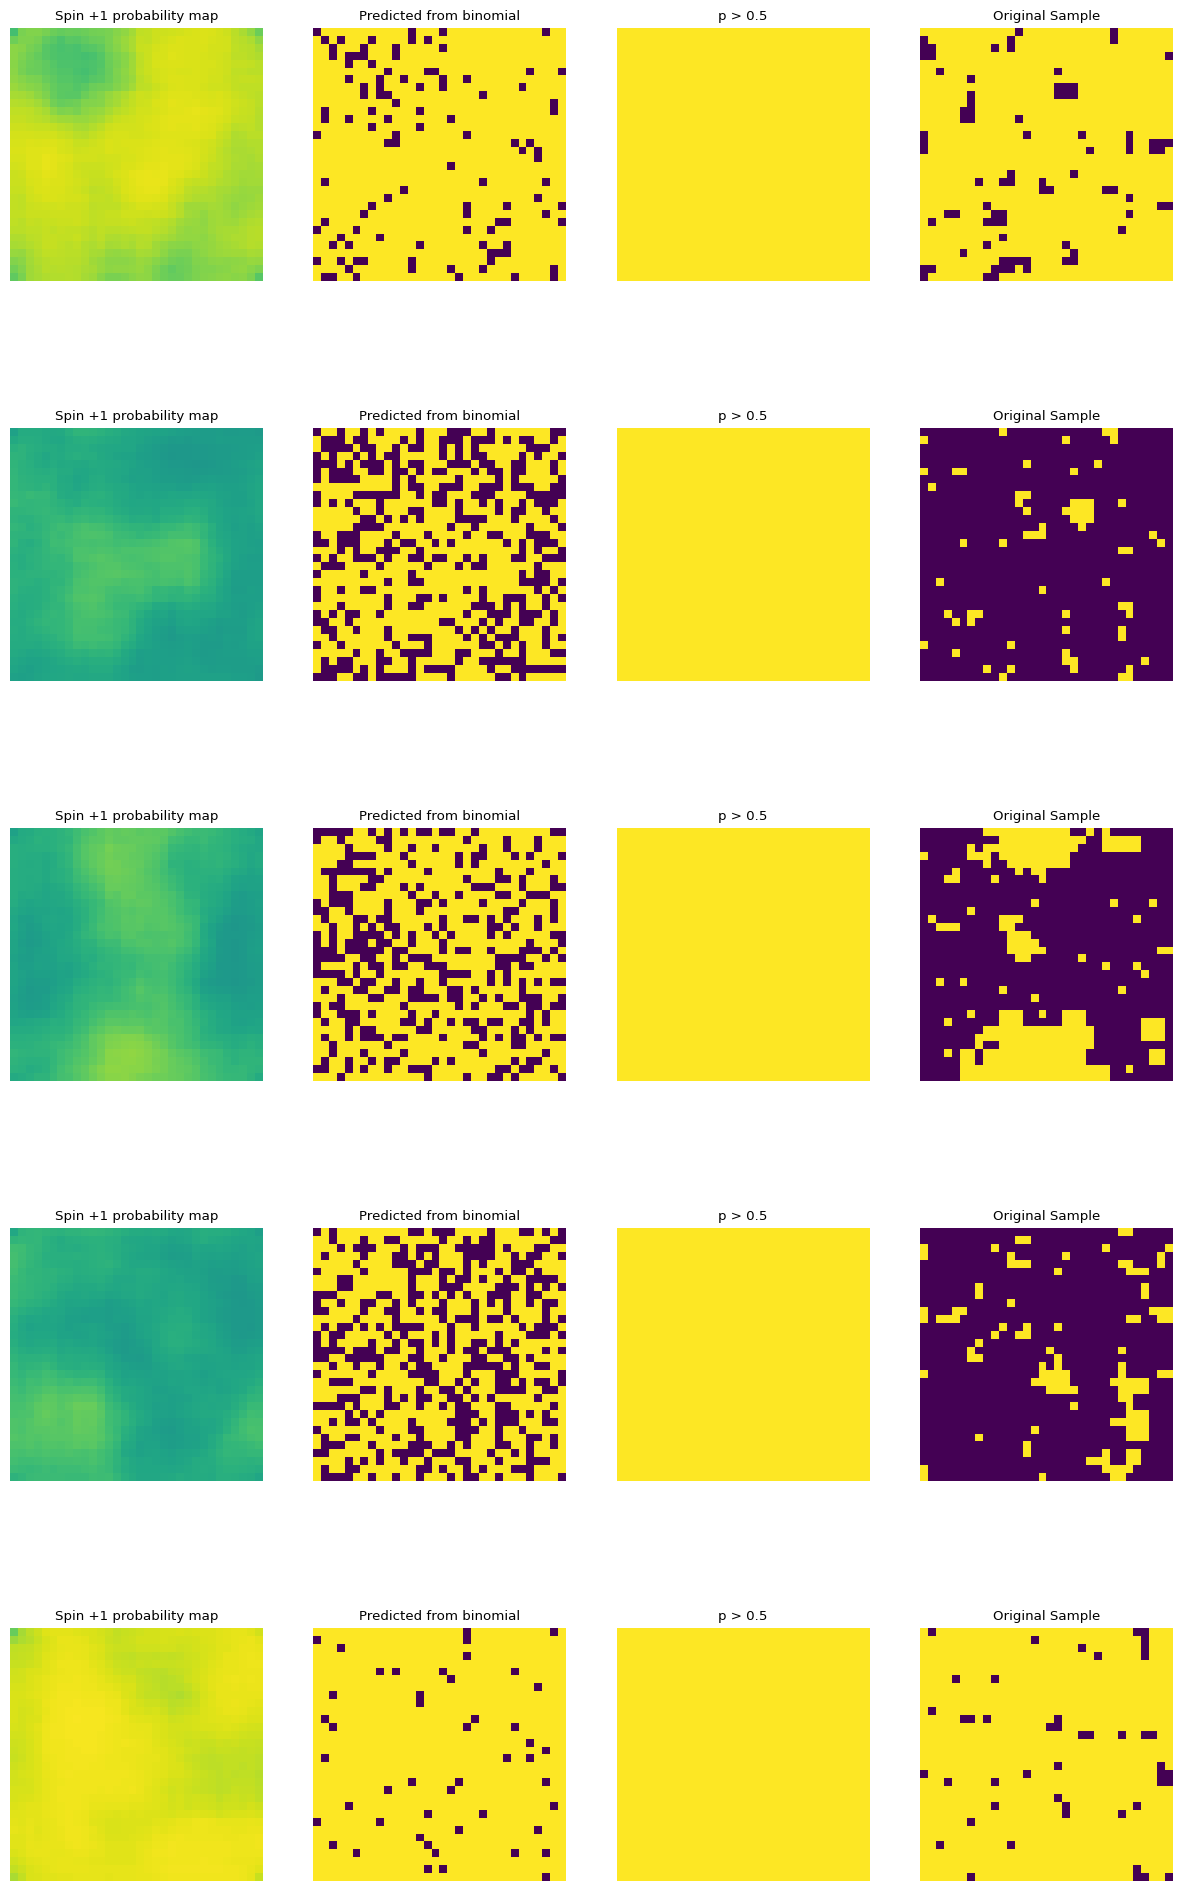

Epoch: 1, Test set ELBO: -330.280517578125, Time needed: 17.538630962371826


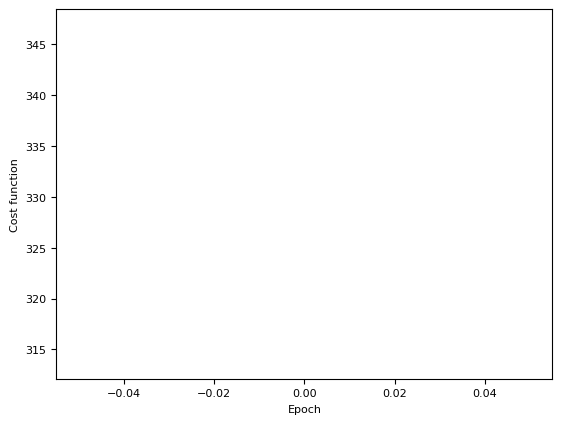

In [8]:
temp = 2.2
model = VAE(latent_dim, lattice_size = 32)
train_at_t(temp, model, results, batch_size, 1, latent_dim, num_examples_to_generate)

## Architecture plots

In [3]:
kernel_size = 3
latent_dim = 200
encoder = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(32, (kernel_size, kernel_size), activation='relu', padding="same", input_shape=(32, 32, 1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(latent_dim + latent_dim)
          ]
)

decoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=kernel_size, strides=(1, 1), padding="same"),
        ]
)

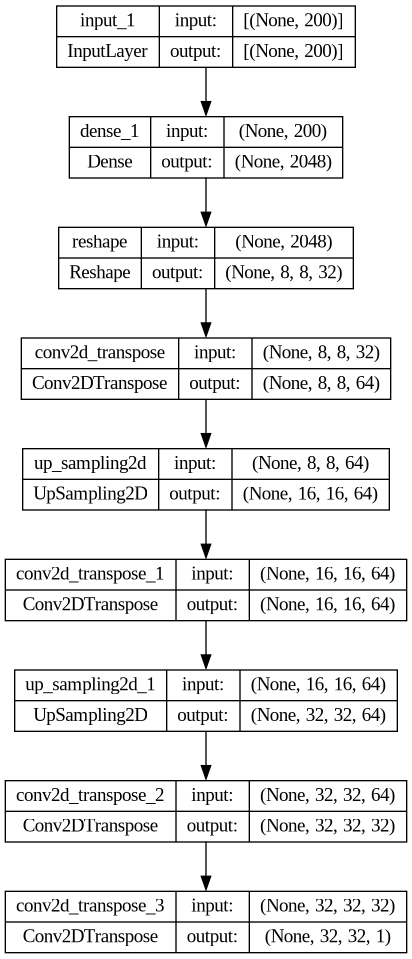

In [5]:
from tensorflow.keras.utils import plot_model

# Plot the encoder model
plot_model(encoder, to_file='encoder.png', show_shapes=True, show_layer_names=True)

# Plot the decoder model
plot_model(decoder, to_file='decoder.png', show_shapes=True, show_layer_names=True)